Bicystal stress driven solution for network plasticity. The code integrates the system of equations:

\begin{equation}
|\dot{h}_{12}| = -\frac{1}{\phi^*_1}\left[-G_2\mbox{sgn}(\dot{V_2})-G_1\mbox{sgn}(\dot{V_1})  -P^0:F^{GB}_{12}+\phi^*_0\right]
\end{equation}
Since $dV_p$ is negative for edge $pq$ the signs are reversed for edge $qp$ producing $-\frac{\partial V_p}{\partial h_{pq}}$ and $-\frac{\partial G_p}{\partial h_{pq}}$.
\begin{equation}
|\dot{h}_{21}| = -\frac{1}{\phi^*_1}\left[G_2\mbox{sgn}(\dot{V_2})+G_1\mbox{sgn}(\dot{V_1})  +P^0:F^{GB}_{12}+\phi^*_0\right]
\end{equation}
Where $G_1$ or $G_2$ is the Gibbs free energy of grain 1 or 2.  
\begin{equation}
G_p = \frac{1}{2}P^0:\mathbb{C}_p^{-1}P^0+P^0:F^{GB}_p + u(\boldsymbol{Q},T)
\end{equation}
The following is done with a sinusoidal loading function.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

# initualize values
phi0 = 0.1
phi1 = 1
Cinv11,Cinv12,Cinv44 = 1/110, -0.34/110, 2*(1+0.34)/110 # moduli for copper
P0 = np.zeros((3,3)) # applied load
Fgb12 = np.zeros((3,3)) # grain boundary shear
Fgb1 = np.zeros((3,3)) # eigenstrain for grain 1
Fgb2 = np.zeros((3,3)) # eigenstrain for grain 2
F0 = np.zeros((3,3)) # strain
F1 = np.zeros((3,3)) # strain for grain 1
F2 = np.zeros((3,3)) # strain for grain 2
Fgb12[0,1] = 0.6
a12 = .5

tfin = 1.5
dt = 0.0001
tt = int(tfin/dt)
V1 = np.zeros(tt+1)
V2 = np.zeros(tt+1)
h12 = np.zeros(tt+1)
time = np.zeros(tt+1)
strain = np.zeros(tt+1)
stress = np.zeros(tt+1)
V1[0] = 0.5
V2[0] = 0.5
v1dot= 0
v2dot = 0
dh12 = 0
dh21 = 0
def CalF(sig):
    Ff = np.zeros((3,3))
    Ff[0,0] = Cinv11*sig[0,0] + Cinv12*sig[1,1]  + Cinv12*sig[2,2]
    Ff[1,1] = Cinv12*sig[0,0] + Cinv11*sig[1,1]  + Cinv12*sig[2,2]
    Ff[2,2] = Cinv12*sig[0,0] + Cinv12*sig[1,1]  + Cinv11*sig[2,2]
    Ff[0,1] = 0.5*Cinv44*sig[0,1]
    Ff[1,2] = 0.5*Cinv44*sig[1,2]
    Ff[2,0] = 0.5*Cinv44*sig[2,0]
    Ff[1,0] = Ff[0,1]
    Ff[2,1] = Ff[1,2]
    Ff[0,2] = Ff[2,0]
    return Ff

def CalGibbs(grain):
    G = 0
    F = np.zeros((3,3))
    F = CalF(P0)
    if(grain == 1):
        for i in range(0,2):
            for j in range(0,2):
                G = G + 1/2*F[i,j]*P0[i,j] + P0[i,j]*Fgb1[i,j]
    elif(grain == 2):
        for i in range(0,2):
            for j in range(0,2):
                G = G + 1/2*F[i,j]*P0[i,j] + P0[i,j]*Fgb2[i,j]             
    return G

# set up rotation matrix
theta = np.radians(0)
c, s = np.cos(theta), np.sin(theta)
rot2 = np.array(((c,0, s),(0,1,0), (-s,0, c)))
Fgb12 = np.matmul(np.matmul(rot2,Fgb12),np.transpose(rot2))

for t in range(tt):
    
    P0[0,1] = .4*np.sin(80*m.pi/(tt)*t)
    P0[1,0] = .4*np.sin(80*m.pi/(tt)*t)
    
    G1 = CalGibbs(1)
    G2 = CalGibbs(2)
    dh12 = -(-G1*np.sign(v1dot) - G2*np.sign(v2dot) - P0[0,1]*Fgb12[0,1] + phi0)/phi1
    dh21 = -(G1*np.sign(v1dot) + G2*np.sign(v2dot) + P0[0,1]*Fgb12[0,1] + phi0)/phi1
    
    if (h12[t] < -1/2 or h12[t] > 1/2):
        dh12 = 0
        dh21 = 0

    
    if(dh12 < 0):
        dh12 = 0
    if(dh21 < 0):
        dh21 = 0
    if(dh12 > 0):
        # V1 gets bigger
        h12[t+1] = h12[t] + dt*dh12 
        Fgb1 = np.add(Fgb1, a12*dh12/V1[t]*dt*Fgb12)
    else: 
        # V1 gets smaller 
        dh12 = -dh21
        h12[t+1] = h12[t] + dt*dh12 
        Fgb2 = np.add(Fgb2, a12*dh12/V2[t]*dt*Fgb12)
    
    v1dot = a12*dh12
    v2dot = -a12*dh12
    
    V1[t+1] = V1[t] + v1dot*dt 
    V2[t+1] = V2[t] + v2dot*dt 
    
    time[t+1] = t*dt
    F0 = CalF(P0)
    stress[t+1] = P0[0,1]
    strain[t+1] = F0[0,1] + Fgb1[0,1] + Fgb2[0,1]
    


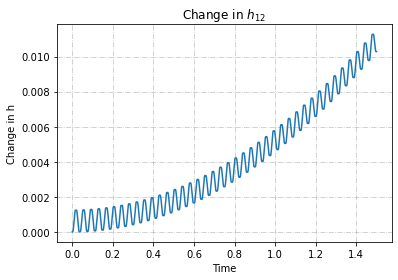

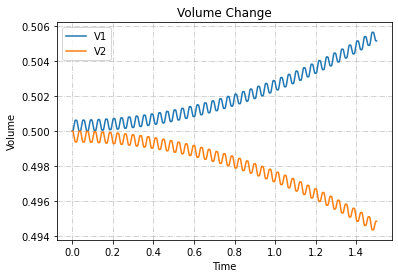

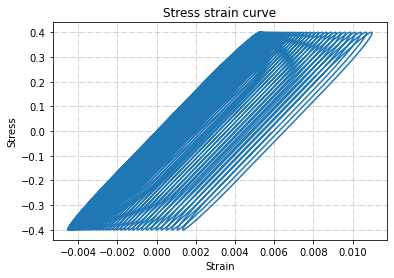

In [14]:

fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel('Time')
plt.ylabel('Change in h')
plt.title('Change in $h_{12}$')
plt.grid(alpha=.7,linestyle='-.')
plt.plot(time,h12)

plt.show()

fig1, ax1 = plt.subplots()
ax1.plot(time, V1)
ax1.plot(time, V2)
ax1.set_xlabel("Time")
ax1.set_ylabel("Volume")
ax1.set_title('Volume Change')
ax1.legend(['V1','V2'])
plt.grid(alpha=.7,linestyle='-.')

fig2, ax2 = plt.subplots()
ax2.plot(strain, stress)
ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress")
ax2.set_title('Stress strain curve')
plt.grid(alpha=.7,linestyle='-.')

Stress driven motion with differing $\phi_0^*$ and interface rotation and was done with linearly increasing $P^0$.

In [5]:
def int_double_stress(phi0,th):
    # initualize values
    phi1 = 0.02
    Cinv11,Cinv12,Cinv44 = 1/110, -0.34/110, 2*(1+0.34)/110 # moduli for copper
    P0 = np.zeros((3,3)) # applied load
    Fgb12 = np.zeros((3,3)) # grain boundary shear
    Fgb1 = np.zeros((3,3)) # eigenstrain for grain 1
    Fgb2 = np.zeros((3,3)) # eigenstrain for grain 2
    F0 = np.zeros((3,3)) # strain
    Fgb12[0,1] = 0.6
    a12 = .5

    tfin = .8
    dt = 0.0001
    tt = int(tfin/dt)
    V1 = np.zeros(tt+1)
    V2 = np.zeros(tt+1)
    h12 = np.zeros(tt+1)
    time = np.zeros(tt+1)
    V1[0] = 0.5
    V2[0] = 0.5
    v1dot= 0
    v2dot = 0
    dh12 = 0
    dh21 = 0
    
    # set up rotation matrix
    theta = np.radians(th)
    c, s = np.cos(theta), np.sin(theta)
    rot2 = np.array(((c,0, s),(0,1,0), (-s,0, c)))
    Fgb12 = np.matmul(np.matmul(rot2,Fgb12),np.transpose(rot2))
    
    for t in range(tt):

        P0[0,1] = .8/(tt)*t
        P0[1,0] = .8/(tt)*t

        G1 = CalGibbs(1)
        G2 = CalGibbs(2)
        dh12 = -(-G1*np.sign(v1dot) - G2*np.sign(v2dot) - P0[0,1]*Fgb12[0,1] + phi0)/phi1
        dh21 = -(G1*np.sign(v1dot) + G2*np.sign(v2dot) + P0[0,1]*Fgb12[0,1] + phi0)/phi1

        if (h12[t] < -1/2 or h12[t] > 1/2):
            dh12 = 0
            dh21 = 0


        if(dh12 < 0):
            dh12 = 0
        if(dh21 < 0):
            dh21 = 0
        if(dh12 > 0):
            # V1 gets bigger
            h12[t+1] = h12[t] + dt*dh12 
            Fgb1 = np.add(Fgb1, a12*dh12/V1[t]*dt*Fgb12)
        else: 
            # V1 gets smaller 
            dh12 = -dh21
            h12[t+1] = h12[t] + dt*dh12 
            Fgb2 = np.add(Fgb2, a12*dh12/V2[t]*dt*Fgb12)

        v1dot = a12*dh12
        v2dot = -a12*dh12

        V1[t+1] = V1[t] + v1dot*dt 
        V2[t+1] = V2[t] + v2dot*dt 

        time[t+1] = t*dt
    return [h12,time]

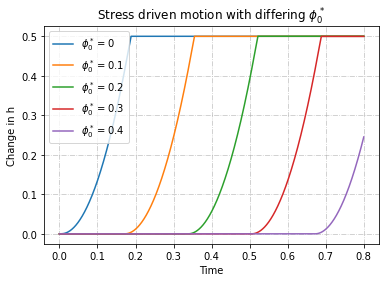

In [6]:
[h12_0,t] = int_double_stress(.0,0)
[h12_1,t] = int_double_stress(.1,0)
[h12_2,t] = int_double_stress(.2,0)
[h12_3,t] = int_double_stress(.3,0)
[h12_4,t] = int_double_stress(.4,0)
fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel('Time')
plt.ylabel('Change in h')
plt.title(r"Stress driven motion with differing $\phi_0^*$")
plt.grid(alpha=.7,linestyle='-.')
plt.plot(t,h12_0)
plt.plot(t,h12_1)
plt.plot(t,h12_2)
plt.plot(t,h12_3)
plt.plot(t,h12_4)
plt.legend([r"$\phi_0^* = 0$",r"$\phi_0^* = 0.1$",r"$\phi_0^* = 0.2$",r"$\phi_0^* = 0.3$",r"$\phi_0^* = 0.4$"])
plt.show()

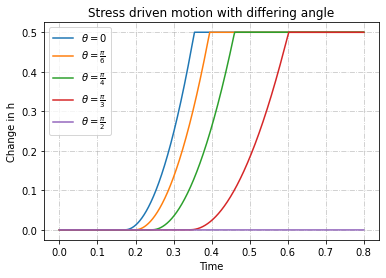

In [7]:
[h12_0,t] = int_double_stress(.1,0)
[h12_30,t] = int_double_stress(.1,30)
[h12_45,t] = int_double_stress(.1,45)
[h12_60,t] = int_double_stress(.1,60)
[h12_90,t] = int_double_stress(.1,90)
fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel('Time')
plt.ylabel('Change in h')
plt.title('Stress driven motion with differing angle')
plt.grid(alpha=.7,linestyle='-.')
plt.plot(t,h12_0)
plt.plot(t,h12_30)
plt.plot(t,h12_45)
plt.plot(t,h12_60)
plt.plot(t,h12_90)
plt.legend([r"$\theta = 0$",r"$\theta = \frac{\pi}{6}$",r"$\theta = \frac{\pi}{4}$",r"$\theta = \frac{\pi}{3}$",r"$\theta = \frac{\pi}{2}$"])
plt.show()

Bicrystal strain driven motion solution for network plasticity. The code integrates the system of equaitons 

\begin{equation}
          |\dot{h}_{12}| = -\frac{1}{\phi^*_1}\left[-A^*_1\mbox{sgn}(\dot{V}_1) - A^*_2\mbox{sgn}(\dot{V}_2) + 4F_{12}^{GB}:\mathbb{C}(F_0 - 2F_{1}^{GB} - 2F_{2}^{GB}) + \phi^*_0\right]
\end{equation}

\begin{equation}
          |\dot{h}_{21}| = -\frac{1}{\phi^*_1}\left[A^*_1\mbox{sgn}(\dot{V}_1) + A^*_2\mbox{sgn}(\dot{V}_2) + 4F_{12}^{GB}:\mathbb{C}(-F_0 + 2F_{1}^{GB} + 2F_{2}^{GB}) + \phi^*_0\right]
\end{equation}

With $A^*_p$ equal to:

\begin{equation}
    A_p^* = \frac{1}{2}\left(\frac{F_0}{V_p}-2F_p^{GB}\right):\mathbb{C}_p\left(\frac{F_0}{V_p}-2F_p^{GB}\right)
\end{equation}

In [39]:

# initualize values
phi0 = .1
phi1 = 10
C11,C12,C44 = 169.3097, 87.2201, 41.0448 # moduli for copper
Cinv11,Cinv12,Cinv44 = 1/110, -0.34/110, 2*(1+0.34)/110 
P0 = np.zeros((3,3)) # applied load
Fgb12 = np.zeros((3,3)) # grain boundary shear
Fgb1 = np.zeros((3,3)) # eigenstrain for grain 1
Fgb2 = np.zeros((3,3)) # eigenstrain for grain 2
F0 = np.zeros((3,3)) # strain
Fgb12[0,1] = 0.5
a12 = 1

tfin = .1
dt = 0.0001
tt = int(tfin/dt)
V1 = np.zeros(tt+1)
V2 = np.zeros(tt+1)
h12 = np.zeros(tt+1)
time = np.zeros(tt+1)
strain = np.zeros(tt+1)
stress = np.zeros(tt+1)
V1[0] = 0.5
V2[0] = 0.5
v1dot= 0
v2dot = 0
dh12 = 0
dh21 = 0

def CalF(sig):
    Ff = np.zeros((3,3))
    Ff[0,0] = Cinv11*sig[0,0] + Cinv12*sig[1,1]  + Cinv12*sig[2,2]
    Ff[1,1] = Cinv12*sig[0,0] + Cinv11*sig[1,1]  + Cinv12*sig[2,2]
    Ff[2,2] = Cinv12*sig[0,0] + Cinv12*sig[1,1]  + Cinv11*sig[2,2]
    Ff[0,1] = 0.5*Cinv44*sig[0,1]
    Ff[1,2] = 0.5*Cinv44*sig[1,2]
    Ff[2,0] = 0.5*Cinv44*sig[2,0]
    Ff[1,0] = Ff[0,1]
    Ff[2,1] = Ff[1,2]
    Ff[0,2] = Ff[2,0]
    return Ff
def CalSig(F):
    sig = np.zeros((3,3))
    
    sig[0,0] = C11*F[0,0] + C12*F[1,1]  + C12*F[2,2]
    sig[1,1] = C12*F[0,0] + C11*F[1,1]  + C12*F[2,2]
    sig[2,2] = C12*F[0,0] + C12*F[1,1]  + C11*F[2,2]
    sig[0,1] = 2*C44*F[0,1]
    sig[1,2] = 2*C44*F[1,2]
    sig[2,0] = 2*C44*F[2,0]
    sig[1,0] = sig[0,1]
    sig[2,1] = sig[1,2]
    sig[0,2] = sig[2,0]
    return sig

def CalA(grain, V):
    
    A = 0
    if(grain == 1):
        temp = F0/V - 2*Fgb1
        P = CalSig(temp)
        for i in range(0,2):
            for j in range(0,2):
                A = A + 0.5*temp[i,j]*P[i,j]
    elif(grain == 2):
        temp = F0/V - 2*Fgb2
        P = CalSig(temp)
        for i in range(0,2):
            for j in range(0,2):
                A = A +  0.5*temp[i,j]*P[i,j]
    return A
    
def CaldAdh (fgbpq):
    dadh = 0
    temp = F0 - 2*Fgb1 - 2*Fgb2
    P = CalSig(temp)
    for i in range(0,2):
        for j in range(0,2):
            dadh = dadh + 4*fgbpq[i,j]*P[i,j]
    
    return dadh
    
# set up rotation matrix
theta = np.radians(0)
c, s = np.cos(theta), np.sin(theta)
rot2 = np.array(((c,0, s),(0,1,0), (-s,0, c)))
Fgb12 = np.matmul(np.matmul(rot2,Fgb12),np.transpose(rot2))

for t in range(tt):
    
    F0[0,1] = .005*np.sin(80*m.pi/(tt)*t)
    F0[1,0] = .005*np.sin(80*m.pi/(tt)*t)
    
    A1 = CalA(1,V1[t])
    A2 = CalA(2,V2[t])
    dadh = CaldAdh(Fgb12)
    dh12 = -(-A1*np.sign(v1dot) - A2*np.sign(v2dot) + dadh + phi0)/phi1
    dh21 = -(A1*np.sign(v1dot) + A2*np.sign(v2dot) - dadh + phi0)/phi1
    
    if (h12[t] < -1/2 or h12[t] > 1/2):
        dh12 = 0
        dh21 = 0

    
    if(dh12 < 0):
        dh12 = 0
    if(dh21 < 0):
        dh21 = 0
    if(dh12 > 0):
        # V1 gets bigger
        h12[t+1] = h12[t] + dt*dh12 
        Fgb1 = np.add(Fgb1, a12*dh12/V1[t]*dt*Fgb12)
    else: 
        # V1 gets smaller 
        dh12 = -dh21
        h12[t+1] = h12[t] + dt*dh12 
        Fgb2 = np.add(Fgb2, a12*dh12/V2[t]*dt*Fgb12)
    
    v1dot = a12*dh12
    v2dot = -a12*dh12
    
    V1[t+1] = V1[t] + v1dot*dt 
    V2[t+1] = V2[t] + v2dot*dt 
    
    time[t+1] = t*dt
    P0 = CalSig(F0)
    stress[t+1] = P0[0,1]
    strain[t+1] = F0[0,1] - V1[t]*Fgb1[0,1] - V2[t]*Fgb2[0,1]

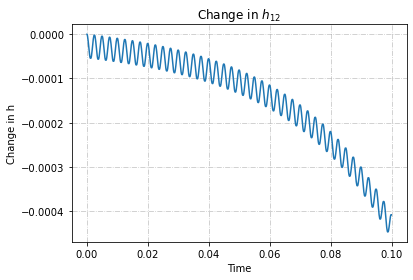

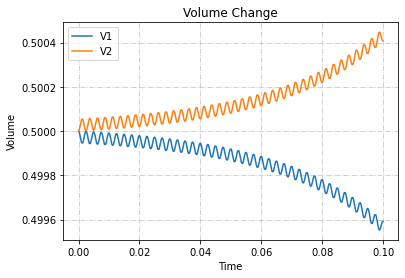

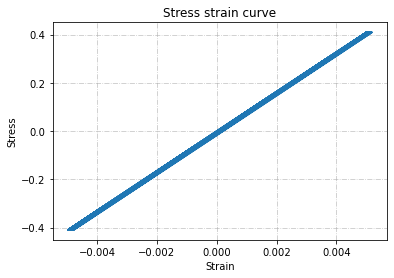

In [40]:
fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel('Time')
plt.ylabel('Change in h')
plt.title('Change in $h_{12}$')
plt.grid(alpha=.7,linestyle='-.')
plt.plot(time,h12)

plt.show()

fig1, ax1 = plt.subplots()
ax1.plot(time, V1)
ax1.plot(time, V2)
ax1.set_xlabel("Time")
ax1.set_ylabel("Volume")
ax1.set_title('Volume Change')
ax1.legend(['V1','V2'])
plt.grid(alpha=.7,linestyle='-.')

fig2, ax2 = plt.subplots()
ax2.plot(strain, stress)
ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress")
ax2.set_title('Stress strain curve')
plt.grid(alpha=.7,linestyle='-.')

In [10]:

def CalF(sig):
    Ff = np.zeros((3,3))
    Ff[0,0] = Cinv11*sig[0,0] + Cinv12*sig[1,1]  + Cinv12*sig[2,2]
    Ff[1,1] = Cinv12*sig[0,0] + Cinv11*sig[1,1]  + Cinv12*sig[2,2]
    Ff[2,2] = Cinv12*sig[0,0] + Cinv12*sig[1,1]  + Cinv11*sig[2,2]
    Ff[0,1] = 0.5*Cinv44*sig[0,1]
    Ff[1,2] = 0.5*Cinv44*sig[1,2]
    Ff[2,0] = 0.5*Cinv44*sig[2,0]
    Ff[1,0] = Ff[0,1]
    Ff[2,1] = Ff[1,2]
    Ff[0,2] = Ff[2,0]
    return Ff
def CalSig(F):
    sig = np.zeros((3,3))
    
    sig[0,0] = C11*F[0,0] + C12*F[1,1]  + C12*F[2,2]
    sig[1,1] = C12*F[0,0] + C11*F[1,1]  + C12*F[2,2]
    sig[2,2] = C12*F[0,0] + C12*F[1,1]  + C11*F[2,2]
    sig[0,1] = 2*C44*F[0,1]
    sig[1,2] = 2*C44*F[1,2]
    sig[2,0] = 2*C44*F[2,0]
    sig[1,0] = sig[0,1]
    sig[2,1] = sig[1,2]
    sig[0,2] = sig[2,0]
    return sig

def CalA(grain, V):
    
    A = 0
    if(grain == 1):
        temp = F0/V - 2*Fgb1
        P = CalSig(temp)
        for i in range(0,2):
            for j in range(0,2):
                A = A + 0.5*temp[i,j]*P[i,j]
    elif(grain == 2):
        temp = F0/V - 2*Fgb2
        P = CalSig(temp)
        for i in range(0,2):
            for j in range(0,2):
                A = A +  0.5*temp[i,j]*P[i,j]
    return A
    
def CaldAdh (fgbpq):
    dadh = 0
    temp = F0 - 2*Fgb1 - 2*Fgb2
    P = CalSig(temp)
    for i in range(0,2):
        for j in range(0,2):
            dadh = dadh + 4*fgbpq[i,j]*P[i,j]
    
    return dadh

def int_double_strain(phi0,th):
    # initualize values
    phi1 = 0.2
    C11,C12,C44 = 169.3097, 87.2201, 41.0448 # moduli for copper
    Cinv11,Cinv12,Cinv44 = 1/110, -0.34/110, 2*(1+0.34)/110 
    P0 = np.zeros((3,3)) # applied load
    Fgb12 = np.zeros((3,3)) # grain boundary shear
    Fgb1 = np.zeros((3,3)) # eigenstrain for grain 1
    Fgb2 = np.zeros((3,3)) # eigenstrain for grain 2
    F0 = np.zeros((3,3)) # strain
    Fgb12[0,1] = 0.5
    a12 = .5

    tfin = .1
    dt = 0.0001
    tt = int(tfin/dt)
    V1 = np.zeros(tt+1)
    V2 = np.zeros(tt+1)
    h12 = np.zeros(tt+1)
    time = np.zeros(tt+1)
    V1[0] = 0.5
    V2[0] = 0.5
    v1dot= 0
    v2dot = 0
    dh12 = 0
    dh21 = 0
    
    # set up rotation matrix
    theta = np.radians(th)
    c, s = np.cos(theta), np.sin(theta)
    rot2 = np.array(((c,0, s),(0,1,0), (-s,0, c)))
    Fgb12 = np.matmul(np.matmul(rot2,Fgb12),np.transpose(rot2))
    for t in range(tt):

        F0[0,1] = .02/(tt)*t
        F0[1,0] = .02/(tt)*t

        A1 = CalA(1,V1[t])
        A2 = CalA(2,V2[t])
        dadh = CaldAdh(Fgb12)
        dh12 = -(-A1*np.sign(v1dot) - A2*np.sign(v2dot) + dadh + phi0)/phi1
        dh21 = -(A1*np.sign(v1dot) + A2*np.sign(v2dot) - dadh + phi0)/phi1
        
        if (h12[t] < -1/2 or h12[t] > 1/2):
            dh12 = 0
            dh21 = 0


        if(dh12 < 0):
            dh12 = 0
        if(dh21 < 0):
            dh21 = 0
        if(dh12 > 0):
            # V1 gets bigger
            h12[t+1] = h12[t] + dt*dh12 
            Fgb1 = np.add(Fgb1, a12*dh12/V1[t]*dt*Fgb12)
        else: 
            # V1 gets smaller 
            dh12 = -dh21
            h12[t+1] = h12[t] + dt*dh12 
            Fgb2 = np.add(Fgb2, a12*dh12/V2[t]*dt*Fgb12)

        v1dot = a12*dh12
        v2dot = -a12*dh12

        V1[t+1] = V1[t] + v1dot*dt 
        V2[t+1] = V2[t] + v2dot*dt 

        time[t+1] = t*dt
    return [h12,time]

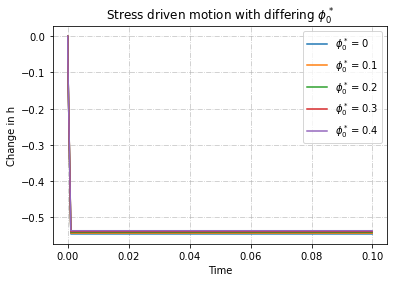

In [11]:
[h12_0,t] = int_double_strain(.0,0)
[h12_1,t] = int_double_strain(.4,0)
[h12_2,t] = int_double_strain(.8,0)
[h12_3,t] = int_double_strain(1.2,0)
[h12_4,t] = int_double_strain(1.6,0)
fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel('Time')
plt.ylabel('Change in h')
plt.title(r"Stress driven motion with differing $\phi_0^*$")
plt.grid(alpha=.7,linestyle='-.')
plt.plot(t,h12_0)
plt.plot(t,h12_1)
plt.plot(t,h12_2)
plt.plot(t,h12_3)
plt.plot(t,h12_4)
plt.legend([r"$\phi_0^* = 0$",r"$\phi_0^* = 0.1$",r"$\phi_0^* = 0.2$",r"$\phi_0^* = 0.3$",r"$\phi_0^* = 0.4$"])

plt.show()

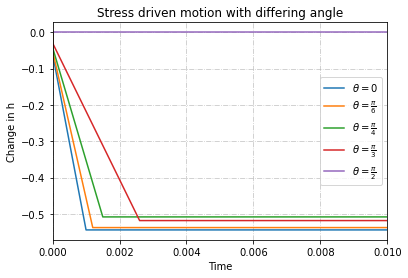

In [12]:
[h12_0,t] = int_double_strain(.3,0)
[h12_30,t] = int_double_strain(.3,30)
[h12_45,t] = int_double_strain(.3,45)
[h12_60,t] = int_double_strain(.3,60)
[h12_90,t] = int_double_strain(.3,90)
fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel('Time')
plt.ylabel('Change in h')
plt.title('Stress driven motion with differing angle')
plt.grid(alpha=.7,linestyle='-.')
plt.plot(t,h12_0)
plt.plot(t,h12_30)
plt.plot(t,h12_45)
plt.plot(t,h12_60)
plt.plot(t,h12_90)
plt.legend([r"$\theta = 0$",r"$\theta = \frac{\pi}{6}$",r"$\theta = \frac{\pi}{4}$",r"$\theta = \frac{\pi}{3}$",r"$\theta = \frac{\pi}{2}$"])
plt.xlim([0, .01])
plt.show()